In [1]:
import os
import sys
import json
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [110]:
pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)

## data load

In [2]:
BASE_DIR = '../mnt/inputs/origin'
TRN_BASE_DIR = '../mnt/inputs/features/train'
TST_BASE_DIR = '../mnt/inputs/features/test'
# BASE_DIR = '../mnt/inputs/features/test'

In [3]:
!ls $BASE_DIR
!ls $TRN_BASE_DIR

data-science-bowl-2019.zip  test.csv	  train2.csv
sample_submission.csv	    train.csv	  train_labels.csv
specs.csv		    train.pkl.gz
specs_w_event_id.csv	    train1.csv
EncodingTitles.pkl  PrevAssessAcc.pkl	      befTargetCntFeatures.pkl
EventCount.pkl	    PrevAssessAccByTitle.pkl  immediatelyBeforeFeatures.pkl
EventCount2.pkl     PrevAssessResult.pkl      worldGameNumeriacalFeatures.pkl
GameDurMiss.pkl     SessionTime2.pkl
KernelBasics3.pkl   Worldcount.pkl


In [4]:
trn_df = pd.read_pickle(f'{BASE_DIR}/train.pkl.gz')
specs_df = pd.read_csv(f'{BASE_DIR}/specs_w_event_id.csv')
display(trn_df.shape, trn_df.head())

(11341042, 11)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
trn_labels_df = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
display(trn_labels_df.shape, trn_labels_df.head())

(17690, 7)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [6]:
tst_df = pd.read_csv(f'{BASE_DIR}/test.csv')
tst_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [7]:
sub_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
sub_df.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


## oof 見てみる

In [84]:
import pickle

with open('../mnt/oofs/e026/e026_oof.pkl', 'rb') as fin:
    oof = pickle.load(fin)
with open('../mnt/oofs/e026/e026_prediction.pkl', 'rb') as fin:
    prediction = pickle.load(fin)

In [9]:
oof.shape

(17690,)

In [10]:
trn_labels_df['y_preds'] = oof

In [11]:
trn_labels_df[['accuracy_group', 'y_preds']].corr('spearman')

,accuracy_group,y_preds
accuracy_group,1.000000,0.008847
y_preds,0.008847,1.000000


In [15]:
trn_labels_df[['accuracy_group', 'y_preds']].corr('spearman')

,accuracy_group,y_preds
accuracy_group,1.000000,0.265434
y_preds,0.265434,1.000000


In [64]:
import scipy as sp
from functools import partial

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=[0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y, initial_coef=[1.0, 1.5, 2.0]):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

def qwk(y_true, y_pred, max_rat=3):
    y_true_ = np.asarray(y_true, dtype=int)
    y_pred_ = np.asarray(y_pred, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    numerator = 0
    for k in range(y_true_.shape[0]):
        i, j = y_true_[k], y_pred_[k]
        hist1[i] += 1
        hist2[j] += 1
        numerator += (i - j) * (i - j)

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator

from collections import Counter
from sklearn.metrics import cohen_kappa_score
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(y_true)
    for k in dist:
        dist[k] /= len(y_true)
    pd.Series(y_true).hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [40]:
kb_df = pd.read_pickle('../mnt/inputs/features/train/KernelBasics3.pkl')

In [65]:
optR = OptimizedRounder()
optR.fit(oof[oof != 0], kb_df['accuracy_group'][oof != 0])
coefficients = optR.coefficients()

opt_preds = optR.predict(oof[oof != 0], coefficients)

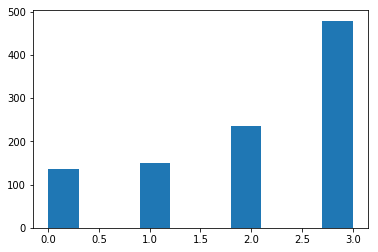

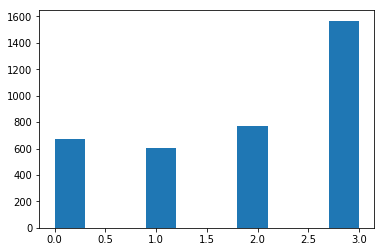

In [89]:
opt_prediction = optR.predict(prediction, coefficients)

plt.hist(opt_prediction)
plt.show()

plt.hist(opt_preds)
plt.show()

In [39]:
qwk(kb_df['accuracy_group'], opt_preds)

0.5989341057094195

In [66]:
qwk(kb_df['accuracy_group'][oof != 0], opt_preds)

0.5754986618584679

('cappa', 0.5327039947764836, True)

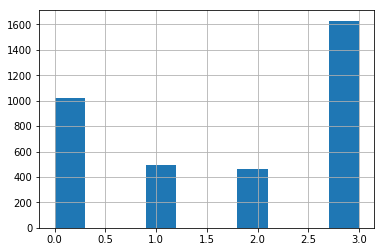

In [70]:
eval_qwk_lgb_regr(kb_df['accuracy_group'][oof != 0], opt_preds)

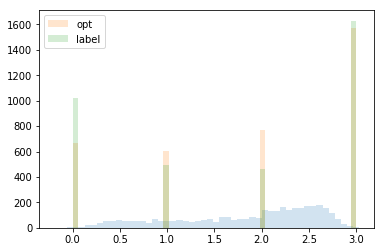

In [69]:
plt.hist(oof[oof != 0], bins=50, alpha=0.2)
plt.hist(opt_preds, bins=50, alpha=0.2, label='opt')
plt.hist(kb_df[oof != 0]['accuracy_group'], bins=50, alpha=0.2, label='label')
plt.legend()
plt.show()

In [75]:
session_lens = pd.read_pickle('../mnt/inputs/features/train/befTargetCntFeatures.pkl').f019_bef_target_cnt

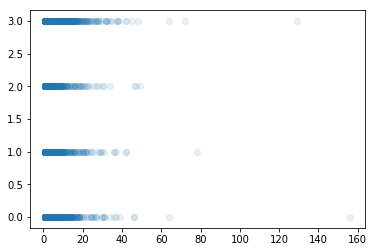

In [79]:
plt.scatter(
    session_lens[oof != 0],
    kb_df['accuracy_group'][oof != 0],
    alpha=0.1
)

In [104]:
test_targets = pd.read_pickle('../mnt/inputs/features/test/targetFeatures.pkl')
test_targets.head()

,installation_id,game_session,num_correct,num_incorrect,accuracy_group
0,00abaee7,8b38fc0d2fd315dc,1.0,0.0,3
0,01242218,009c890ce6c4f3e3,1.0,1.0,2
1,01242218,31423dbcd717919e,1.0,1.0,2
2,01242218,597a8839a5a3468d,1.0,2.0,1
3,01242218,ab61cae5e3215355,0.0,3.0,0


In [82]:
ls ../mnt/inputs/features/test/

EncodingTitles.pkl  PrevAssessAccByTitle.pkl  immediatelyBeforeFeatures.pkl
GameDurMiss.pkl     SessionTime2.pkl          worldGameNumeriacalFeatures.pkl
KernelBasics3.pkl   Worldcount.pkl
PrevAssessAcc.pkl   befTargetCntFeatures.pkl


In [105]:
imp_df = pd.read_csv('../mnt/importances/e026.csv')
imp_df.head()

,feature,importance,fold
0,12 Monkeys,0.000000,0
1,Air Show,538.143310,0
2,All Star Sorting,1429.983296,0
3,Balancing Act,0.000000,0
4,Bird Measurer (Assessment),636.133198,0


In [106]:
imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index()

,feature,importance
0,title_enc,95178.224400
1,as_cum_acc,74850.375048
2,title_type_cnt_Crystal Caves - Level 3_Clip,37385.272971
3,as_prev_acc,26717.439460
4,cum_accuracy,22991.470853
...,...,...
220,Magma Peak - Level 2,0.000000
221,Magma Peak - Level 1,0.000000
222,Lifting Heavy Things,0.000000
223,Welcome to Lost Lagoon!,0.000000


In [111]:
imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index().head(100)

,feature,importance
0,title_enc,95178.224400
1,as_cum_acc,74850.375048
2,title_type_cnt_Crystal Caves - Level 3_Clip,37385.272971
3,as_prev_acc,26717.439460
4,cum_accuracy,22991.470853
5,accum_acc_gr_0,16984.686164
6,f008_1th_before_session_world_LE,13655.434098
7,f013_worldwise_game_world_accracy_mean_mean,11205.344388
8,as_acc_inc_num,9508.581573
9,as_acc_c_num,8345.734604


In [107]:
imp_df[imp_df.feature.str.contains('prev_gs_duration')]

,feature,importance,fold
118,prev_gs_duration,1604.918631,0
120,prev_gs_durationrmean,3223.340843,0
121,prev_gs_durationrstd,3410.138787,0
122,prev_gs_durationrmax,2962.106423,0
123,prev_gs_durationrmin,478.663492,0
343,prev_gs_duration,1799.442620,1
345,prev_gs_durationrmean,3693.557187,1
346,prev_gs_durationrstd,3515.118194,1
347,prev_gs_durationrmax,2842.201614,1
348,prev_gs_durationrmin,265.381059,1


In [33]:
from sklearn.model_selection import GroupKFold as GKF

gkf = GKF(5)

kb_df = kb_df.reset_index(drop=True)

kb_df['y_preds'] = oof
kb_df['fold'] = None
for fold, (i, j) in enumerate(list(gkf.split(kb_df['installation_id'], kb_df['accuracy_group'], kb_df['installation_id']))):
    kb_df.loc[j, 'fold'] = fold

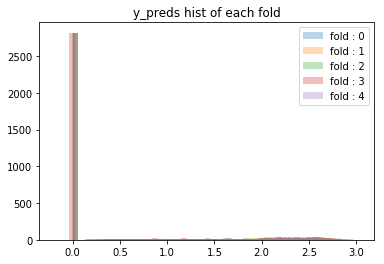

In [34]:
for fold in range(5):
    plt.hist(kb_df.query(f'fold == {fold}').y_preds, bins=50, alpha=0.3, label=f'fold : {fold}')
plt.title('y_preds hist of each fold')
plt.legend()